# Kärppädatan analysointi

karppadataa.csv sisältää tilastotietoa kaikista 616:sta Oulun Kärppien runkosarjaottelusta (huom. ei playoffs-, CHL- tai harjoituspelejä) kuluvalta vuosikymmeneltä.
Eurohockey-sivulta löytyi hyvin tilastoa peleistä vuoteen 2018 asti, muutamaa katsojamääräpuutosta lukuun ottamatta. Vuoden 2019 tilastot ja yksittäiset puutokset tilastoissa saatiin Oulun Kärppien nettisivuilta ja Wikipediasta.

Tilastojen tarkastelemisessa ja visualisoinnissa käytetään matplotlib-kirjastoa.

Tiedot csv-tiedoston riveillä ovat tässä järjestyksessä:
Spectators, Year, Month, Weekday, Date, Timevalue, Time, Won, Score, Homegame, Opponent, Winstreak, Wins/losses

Tehdään aluksi yleiskatsaus Kärppien suoritukseen viimeisen 10 vuoden ajalta.

In [1]:
import matplotlib.pyplot as plt # Tuodaan piirtokirjasto
import csv # Tuodaan kirjasto csv-tiedoston käsittelyä varten

vuodet = []
voittoprosentit = []
maalit, maalitOmiin = [], []
ma, mao = 0, 0
voitot, pelit = 0, 0 # Väliaikaiset muuttujat johon yhteenlasketaan kunkin vuoden pelejä/voittoja
nykyVuosi = "10" # Tiedetään, että tilastointi alkaa vuodesta -10

with open("karppadataa.csv", "r") as karppatiedosto:
    karppadata = csv.reader(karppatiedosto, delimiter=",")
    next(karppadata) # Skipataan otsikointirivi
    
    for rivi in karppadata:
        if rivi[1] != nykyVuosi:
            vuodet.append(nykyVuosi)
            voittoprosentit.append(voitot/pelit)
            maalit.append(ma/pelit)
            maalitOmiin.append(mao/pelit)
            voitot, pelit = 0, 0
            ma, mao = 0, 0
            nykyVuosi = rivi[1]
        pelit += 1
        if rivi[9] == "1":
            ma += int(rivi[8][0])
            mao += int(rivi[8][2])
        else:
            mao += int(rivi[8][0])
            ma += int(rivi[8][2])
            
        if rivi[7] == "1":
            voitot += 1
            
    vuodet.append(nykyVuosi)
    voittoprosentit.append(voitot/pelit)
    maalit.append(ma/pelit)
    maalitOmiin.append(mao/pelit)

    

# Voittoprosenttikaavio
plt.plot(vuodet, voittoprosentit)
plt.ylabel("Voittoprosentti")
plt.xlabel("Vuosi")
plt.show()

<Figure size 640x480 with 1 Axes>

Kuten taulukosta huomaa, 2002-2009 vuosien mitaliputken jälkeinen notkahdus lähetti Kärpät vaikeampiin peleihin. 2010-vuodesta eteenpäin Kärppien kehitys on kuitenkin ollut nousujohdanteista ja ainoa huono kausi on ollut 16/17, jolloin Kärppien sijoitus runkosarjan loppuessa oli 8. (aikaisempi vuosi 2. ja seuraava 1.)

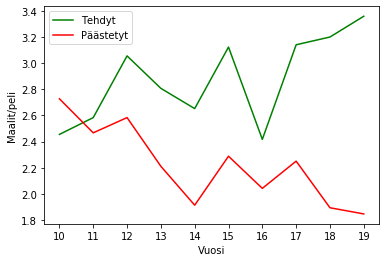

In [2]:
# Maalikaavio
plt.plot(vuodet, maalit, "-g", label="Tehdyt")
plt.plot(vuodet, maalitOmiin, "-r", label="Päästetyt")
plt.legend(loc="upper left")
plt.ylabel("Maalit/peli")
plt.xlabel("Vuosi")

plt.show()

Tässä taulukossa on kuvattu Kärppien maalit vuosittain. Alkupäässä tilastoja Päästettyjä maaleja on vielä enemmän, mutta hyvää vauhtia ne kääntyvät parempaan päin. Luonnollisesti kun maaleja tekee enemmän kuin päästää tulos on hyvää. Nykyisen kauden Kärpät ovat aloittaneet vahvasti ja varsinkin heidän maalivahti-/puolustuspelaaminen on ollut omiaan. Se näkyy hyvin tässä kaaviossa.

Seuraavaksi kiinnitetään huomiota siihen, minä viikonpäivänä pelit ovat.

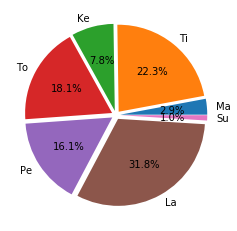

In [3]:
wkday = ["Ma", "Ti", "Ke", "To", "Pe", "La", "Su"]
dayCount = [0, 0, 0, 0, 0, 0, 0]
dayWins = [0, 0, 0, 0, 0, 0, 0]

with open("karppadataa.csv", "r") as karppatiedosto:
    karppadata = csv.reader(karppatiedosto, delimiter=",")
    next(karppadata) # Skipataan otsikointirivi
    
    for rivi in karppadata:
        day = int(rivi[3])
        dayCount[day] += 1
        if rivi[7] == "1":
            dayWins[day] += 1
        
plt.pie(dayCount, explode=[0.05 for _ in range(7)], labels=wkday, autopct='%1.1f%%')
plt.show()

Maanantai- ja sunnuntaipelit ovat harvinaisia. Lauantai ja torstai ovat pelipäivinä lähes puolet ajasta (49.9%).

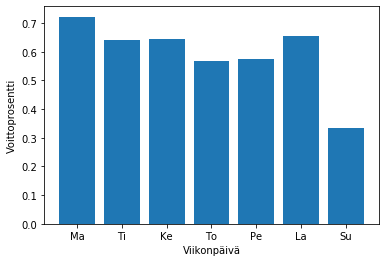

In [4]:
plt.bar(wkday, [dayWins[i]/dayCount[i] for i in range(7)])
plt.ylabel("Voittoprosentti")
plt.xlabel("Viikonpäivä")
plt.show()

Vaikka sunnuntain matalin voittoprosentti ei yllätä, sillä edeltävänä päivänä on usein peli, voittoprosentin dippaus on huomattava. Myös maanantain korkeaa voittoprosenttia voidaan yrittää perustella sillä, että sunnuntait ovat usein lepopäiviä. Todennäköisesti molemmat joukkueen ovat silloin levänneitä ja pelaavat parastaan.
Maanantain ja sunnuntain otteluja on kuitenkin hyvin vähän joten niiden voittoprosentit voivat olla harhaanjohtavia.

Seuraavaksi tarkistellaan lähemmin miten kaksi peräkkäistä pelipäivää vaikuttavat jälkimmäisen lopputulokseen.

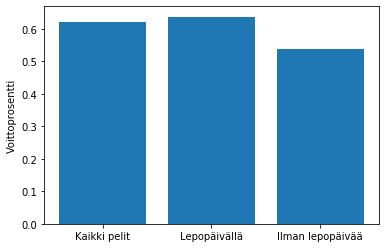

In [7]:
import datetime

pjelp = 0 # Pelit joita ennen lepopäivä
pjepp = 0 # Pelit joita ennen pelipäivä
pjelpv, pjeppv = 0, 0 # Voitot


with open("karppadataa.csv", "r") as karppatiedosto:
    karppadata = csv.reader(karppatiedosto, delimiter=",")
    next(karppadata) # Skipataan otsikointirivi
    epp = "" # Edellinen pelipäivä

    for rivi in karppadata:
        gdate = datetime.datetime.strptime(rivi[4], '%Y-%m-%d').date()
        yesterday = (gdate - datetime.timedelta(1)).strftime('%Y-%m-%d')
        if str(epp) == str(yesterday):
            pjepp += 1
            if rivi[7] == "1":
                pjeppv += 1
        
        else:
            pjelp += 1
            if rivi[7] == "1":
                pjelpv += 1
                
        epp = gdate
        
        
plt.bar(["Kaikki pelit", "Lepopäivällä", "Ilman lepopäivää"],
                            [(pjelpv+pjeppv)/(pjelp+pjepp),pjelpv/pjelp, pjeppv/pjepp])
plt.ylabel("Voittoprosentti")
plt.show()

Kaikkien pelien voittoprosentti on noin 62 %, lepopäivän jälkeisten pelien voittoprosentti on noin 64 % ja ilman lepopäivää pelattujen pelien voittoprosentti on noin 54 %. Lepopäivättömiä pelejä on yhteensä vain 95, mutta ero voittoprosentissa on silti merkittävä.